<a href="https://colab.research.google.com/github/chaerui7967/stock_predict_news_and_youtube/blob/master/lstm_%EC%9E%AC%EB%AC%B4%EC%A0%95%EB%B3%B4_%ED%95%98%EC%9D%B4%EB%8B%89%EC%8A%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 재무지표를 포함한 lstm 종가 예측

## 라이브러리 설치

In [1]:
# 필요 라이브러리 설치
!pip install finance-datareader
!pip install pykrx

     |████████████████████████████████| 81 kB 6.3 MB/s 
     |████████████████████████████████| 60 kB 7.2 MB/s 
     |████████████████████████████████| 251 kB 46.9 MB/s 


## 패키지 로딩 및 함수 로딩

In [2]:
# 필요 라이브러리
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 주식가격 로딩
import FinanceDataReader as fdr
from pykrx import stock

import datetime

In [3]:
def money_sur(stock_name, start, end):

  # 라이브러리를 찾음... 한방에 나옴...
    start_date = start
    end_date = end
    sample_code = stock_name

    dataset = fdr.DataReader(sample_code, start = start_date, end = end_date )
    dataset = dataset.reset_index()
    df = stock.get_market_fundamental_by_date(fromdate=start_date, todate=end_date, ticker=sample_code)
    df = df.reset_index()
    df.columns = ['Date','BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS']
    data = pd.merge(dataset, df, on='Date')

    return data

## 데이터 로드

In [4]:
end_date = datetime.datetime.now().strftime("%Y%m%d")
df = money_sur('000660',2018, end_date)

In [5]:
df

,Date,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS
0,2018-01-02,77300,77300,76200,76600,2014838,0.001307,32990,18.31,2.32,4184,0.78,600
1,2018-01-03,78100,78800,77300,77700,3097644,0.014360,32990,18.57,2.36,4184,0.77,600
2,2018-01-04,78700,79700,77100,77100,3729328,-0.007722,32990,18.43,2.34,4184,0.78,600
3,2018-01-05,78400,79400,78300,79300,3395065,0.028534,32990,18.95,2.40,4184,0.76,600
4,2018-01-08,79500,80000,77400,78200,2960495,-0.013871,32990,18.69,2.37,4184,0.77,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,2021-09-10,103500,105500,103000,105000,1999369,0.019417,71275,15.10,1.47,6952,1.11,1170
912,2021-09-13,105000,107000,104000,106500,1923344,0.014286,71275,15.32,1.49,6952,1.10,1170
913,2021-09-14,107500,108500,106500,107500,2463248,0.009390,71275,15.46,1.51,6952,1.09,1170
914,2021-09-15,107500,107500,105500,107500,2933797,0.000000,71275,15.46,1.51,6952,1.09,1170


## 데이터 전처리

In [6]:
df1 = df.set_index('Date')

In [7]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


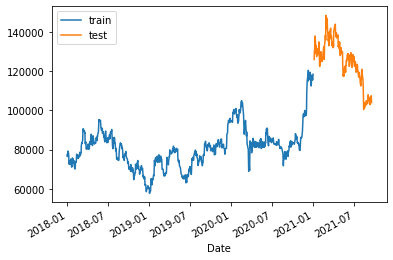

In [8]:
# test --> 21년 이후 , train --> 18~20
split_date = pd.Timestamp('01-01-2021')

train = df1.loc[:split_date, ]
test = df1.loc[split_date:, ]

ax = train['Close'].plot()
test['Close'].plot(ax=ax)
plt.legend(['train', 'test'])

In [9]:
# 스케일링
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

train_sc

array([[0.32195122, 0.3008    , 0.32072368, ..., 0.06426056, 0.06976741,
        0.        ],
       [0.33495935, 0.3248    , 0.33881579, ..., 0.06426056, 0.06395346,
        0.        ],
       [0.34471545, 0.3392    , 0.33552632, ..., 0.06426056, 0.06976741,
        0.        ],
       ...,
       [1.        , 0.976     , 0.95888158, ..., 0.        , 0.122093  ,
        0.44444444],
       [0.98373984, 0.96      , 0.94243421, ..., 0.        , 0.11627906,
        0.44444444],
       [0.95121951, 0.96      , 0.95065789, ..., 0.        , 0.10465113,
        0.44444444]])

In [10]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'BPS', 'PER', 'PBR',
       'EPS', 'DIV', 'DPS'],
      dtype='object')

In [11]:
scale_cols = list(df1.columns)

train_sc_df = pd.DataFrame(train_sc, columns=[scale_cols], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=[scale_cols], index=test.index)

In [ ]:
# 종가로만 예측 시
# train_close = pd.DataFrame(train_sc_df[('Close',)])
# test_close = pd.DataFrame(test_sc_df[('Close',)])

In [12]:
for i in scale_cols:
  for s in range(1, 13):  
    train_sc_df[(i+'shift_{}'.format(s),)] = train_sc_df[(i,)].shift(s)
    test_sc_df[(i+'shift_{}'.format(s),)] = test_sc_df[(i,)].shift(s)

train_sc_df.head(13)
train_sc_df.shape

(738, 156)

In [13]:
test_sc_df.shape

(178, 156)

In [14]:
train_sc_df.columns

MultiIndex([(       'Open',),
            (       'High',),
            (        'Low',),
            (      'Close',),
            (     'Volume',),
            (     'Change',),
            (        'BPS',),
            (        'PER',),
            (        'PBR',),
            (        'EPS',),
            ...
            ( 'DPSshift_3',),
            ( 'DPSshift_4',),
            ( 'DPSshift_5',),
            ( 'DPSshift_6',),
            ( 'DPSshift_7',),
            ( 'DPSshift_8',),
            ( 'DPSshift_9',),
            ('DPSshift_10',),
            ('DPSshift_11',),
            ('DPSshift_12',)],
           length=156)

In [15]:
train_sc_df.head(13)

,Open,High,Low,Close,Volume,Change,BPS,PER,PBR,EPS,DIV,DPS,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.321951,0.3008,0.320724,0.300955,0.066316,0.409709,0.0,0.406037,0.757062,0.064261,0.069767,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.334959,0.3248,0.338816,0.318471,0.153390,0.467774,0.0,0.412861,0.779661,0.064261,0.063953,0.0,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320724,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,0.344715,0.3392,0.335526,0.308917,0.204187,0.369543,0.0,0.409186,0.768362,0.064261,0.069767,0.0,0.334959,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3248,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.338816,0.320724,NaN,NaN,...,NaN,NaN,NaN,NaN,0.064261,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063953,0.069767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,0.339837,0.3344,0.355263,0.343949,0.177307,0.530825,0.0,0.422835,0.802260,0.064261,0.058140,0.0,0.344715,0.334959,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3392,0.3248,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.335526,0.338816,0.320724,NaN,...,NaN,NaN,NaN,NaN,0.064261,0.064261,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069767,0.063953,0.069767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-08,0.357724,0.3440,0.340461,0.326433,0.142361,0.342189,0.0,0.416010,0.785311,0.064261,0.063953,0.0,0.339837,0.344715,0.334959,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3344,0.3392,0.3248,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.355263,0.335526,0.338816,0.320724,...,NaN,NaN,NaN,NaN,0.064261,0.064261,0.064261,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.058140,0.069767,0.063953,0.069767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-09,0.338211,0.3264,0.322368,0.305732,0.173191,0.329944,0.0,0.407874,0.762712,0.064261,0.069767,0.0,0.357724,0.339837,0.344715,0.334959,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3440,0.3344,0.3392,0.3248,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.340461,0.355263,0.335526,0.338816,...,NaN,NaN,NaN,NaN,0.064261,0.064261,0.064261,0.064261,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063953,0.058140,0.069767,0.063953,0.069767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-10,0.312195,0.2912,0.259868,0.242038,0.637991,0.172509,0.0,0.382677,0.694915,0.064261,0.093023,0.0,0.338211,0.357724,0.339837,0.344715,0.334959,0.321951,NaN,NaN,NaN,NaN,NaN,NaN,0.3264,0.3440,0.3344,0.3392,0.3248,0.3008,NaN,NaN,NaN,NaN,NaN,NaN,0.322368,0.340461,0.355263,0.335526,...,NaN,NaN,NaN,NaN,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,NaN,NaN,NaN,NaN,NaN,NaN,0.069767,0.063953,0.058140,0.069767,0.

In [16]:
X_train = train_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_train = train_sc_df.dropna()[['Close']]

X_test = test_sc_df.dropna().drop(columns=scale_cols, axis=1)
y_test = test_sc_df.dropna()[['Close']]

X_train.head()

,Openshift_1,Openshift_2,Openshift_3,Openshift_4,Openshift_5,Openshift_6,Openshift_7,Openshift_8,Openshift_9,Openshift_10,Openshift_11,Openshift_12,Highshift_1,Highshift_2,Highshift_3,Highshift_4,Highshift_5,Highshift_6,Highshift_7,Highshift_8,Highshift_9,Highshift_10,Highshift_11,Highshift_12,Lowshift_1,Lowshift_2,Lowshift_3,Lowshift_4,Lowshift_5,Lowshift_6,Lowshift_7,Lowshift_8,Lowshift_9,Lowshift_10,Lowshift_11,Lowshift_12,Closeshift_1,Closeshift_2,Closeshift_3,Closeshift_4,...,PBRshift_9,PBRshift_10,PBRshift_11,PBRshift_12,EPSshift_1,EPSshift_2,EPSshift_3,EPSshift_4,EPSshift_5,EPSshift_6,EPSshift_7,EPSshift_8,EPSshift_9,EPSshift_10,EPSshift_11,EPSshift_12,DIVshift_1,DIVshift_2,DIVshift_3,DIVshift_4,DIVshift_5,DIVshift_6,DIVshift_7,DIVshift_8,DIVshift_9,DIVshift_10,DIVshift_11,DIVshift_12,DPSshift_1,DPSshift_2,DPSshift_3,DPSshift_4,DPSshift_5,DPSshift_6,DPSshift_7,DPSshift_8,DPSshift_9,DPSshift_10,DPSshift_11,DPSshift_12
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-18,0.274797,0.247154,0.263415,0.256911,0.255285,0.312195,0.338211,0.357724,0.339837,0.344715,0.334959,0.321951,0.2640,0.2592,0.2496,0.2560,0.2448,0.2912,0.3264,0.3440,0.3344,0.3392,0.3248,0.3008,0.279605,0.263158,0.259868,0.251645,0.251645,0.259868,0.322368,0.340461,0.355263,0.335526,0.338816,0.320724,0.261146,0.265924,0.238854,0.265924,...,0.802260,0.768362,0.779661,0.757062,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.063953,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-19,0.297561,0.274797,0.247154,0.263415,0.256911,0.255285,0.312195,0.338211,0.357724,0.339837,0.344715,0.334959,0.2928,0.2640,0.2592,0.2496,0.2560,0.2448,0.2912,0.3264,0.3440,0.3344,0.3392,0.3248,0.294408,0.279605,0.263158,0.259868,0.251645,0.251645,0.259868,0.322368,0.340461,0.355263,0.335526,0.338816,0.278662,0.261146,0.265924,0.238854,...,0.785311,0.802260,0.768362,0.779661,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.081395,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.063953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-22,0.289431,0.297561,0.274797,0.247154,0.263415,0.256911,0.255285,0.312195,0.338211,0.357724,0.339837,0.344715,0.2768,0.2928,0.2640,0.2592,0.2496,0.2560,0.2448,0.2912,0.3264,0.3440,0.3344,0.3392,0.268092,0.294408,0.279605,0.263158,0.259868,0.251645,0.251645,0.259868,0.322368,0.340461,0.355263,0.335526,0.248408,0.278662,0.261146,0.265924,...,0.762712,0.785311,0.802260,0.768362,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.093023,0.081395,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.069767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-23,0.248780,0.289431,0.297561,0.274797,0.247154,0.263415,0.256911,0.255285,0.312195,0.338211,0.357724,0.339837,0.2288,0.2768,0.2928,0.2640,0.2592,0.2496,0.2560,0.2448,0.2912,0.3264,0.3440,0.3344,0.230263,0.268092,0.294408,0.279605,0.263158,0.259868,0.251645,0.251645,0.259868,0.322368,0.340461,0.355263,0.213376,0.248408,0.278662,0.261146,...,0.694915,0.762712,0.785311,0.802260,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.064261,0.104651,0.093023,0.081395,0.087209,0.087209,0.098837,0.087209,0.098837,0.093023,0.069767,0.063953,0.058140,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-24,0.232520,0.248780,0.289431,0.297561,0.274797,0.247154,0.263415,0.256911,0.255285,0.312195,0.338211,0.357724,0.2192,0.2288,0.2768,0.2928,0.2640,0.2592,0.2496,0.2560,0.2448,0.2912,0.3264,0.3440,0.233553,0.230263,0.268092,0.294408,0.279605,0.263158,0.259868,0.251645,0.251645,0.259868,0.322368,0.340461,0.216561,0.213376,0.248408,0.278662,...,0.689266,0.694915,0.7

In [17]:
print(type(X_train))
X_train = X_train.values
print(type(X_train))
X_test= X_test.values
y_train = y_train.values
y_test = y_test.values
 

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(726, 144)
(726, 1)
(166, 144)
(166, 1)


In [18]:
X_train_t = X_train.reshape(X_train.shape[0], 12, 12)
X_test_t = X_test.reshape(X_test.shape[0], 12, 12)

## LSTM 실행

### tensor 사용해서 window 만들기

In [ ]:
# import tensorflow as tf

# def windowed_dataset(series, window_size, batch_size, shuffle):
#     series = tf.expand_dims(series, axis=-1)
#     ds = tf.data.Dataset.from_tensor_slices(series)
#     ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
#     ds = ds.flat_map(lambda w: w.batch(window_size + 1))
#     if shuffle:
#         ds = ds.shuffle(1000)
#     ds = ds.map(lambda w: (w[:-1], w[-1]))
#     return ds.batch(batch_size).prefetch(1)

# WINDOW_SIZE=20
# BATCH_SIZE=32

In [ ]:
# # trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋 입니다.
# train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
# test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [ ]:
# # X: (batch_size, window_size, feature)
# # Y: (batch_size, feature)
# for data in train_data.take(1):
#     print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
#     print(f'데이터셋(Y) 구성(batch_size, feature갯수): {data[1].shape}')

### 모델

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = Sequential()

model.add(LSTM(64,
               input_shape = (12, 12),
               return_sequences= True))
model.add(LSTM(64,
               return_sequences = False))
model.add(Dense(32, activation = 'tanh'))
model.add(Dense(1))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            19712     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 54,849
Trainable params: 54,849
Non-trainable params: 0
_________________________________________________________________


In [25]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

# earlystopping은 30번 epoch통안 val_loss 개선이 없다면 학습 중지
earlystopping = EarlyStopping(monitor='val_loss', patience=30)
# val_loss 기준 체크포인터도 생성
filename = 'lstm_hy.h5'
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [26]:
history = model.fit(X_train_t, y_train, validation_data=(X_test_t,y_test),
                    epochs=300, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/300
23/23 [==============================] - 5s 50ms/step - loss: 0.0169 - mse: 0.0337 - val_loss: 0.1927 - val_mse: 0.3853

Epoch 00001: val_loss improved from inf to 0.19267, saving model to lstm_hy.h5
Epoch 2/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0082 - mse: 0.0164 - val_loss: 0.1308 - val_mse: 0.2615

Epoch 00002: val_loss improved from 0.19267 to 0.13077, saving model to lstm_hy.h5
Epoch 3/300
23/23 [==============================] - 0s 12ms/step - loss: 0.0055 - mse: 0.0110 - val_loss: 0.0549 - val_mse: 0.1098

Epoch 00003: val_loss improved from 0.13077 to 0.05491, saving model to lstm_hy.h5
Epoch 4/300
23/23 [==============================] - 0s 13ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0131 - val_mse: 0.0261

Epoch 00004: val_loss improved from 0.05491 to 0.01305, saving model to lstm_hy.h5
Epoch 5/300
23/23 [==============================] - 0s 11ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 0.0026 - val_mse: 0.0053

Epoch 0

In [28]:
model.load_weights(filename)
pred = model.predict(X_test_t)

In [29]:
def reverse_min_max_scaling(org_x, x): #종가 예측값
    org_x_np = np.asarray(org_x) 
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [30]:
pred.shape

(166, 1)

In [40]:
test_ttt = test['Close'][12:]

In [41]:
pred_act = reverse_min_max_scaling(test_ttt, pred)

In [42]:
pred_act.shape

(166, 1)

In [44]:
pred_act[-1], test_ttt[-1]

(array([139851.6640625]), 104000)

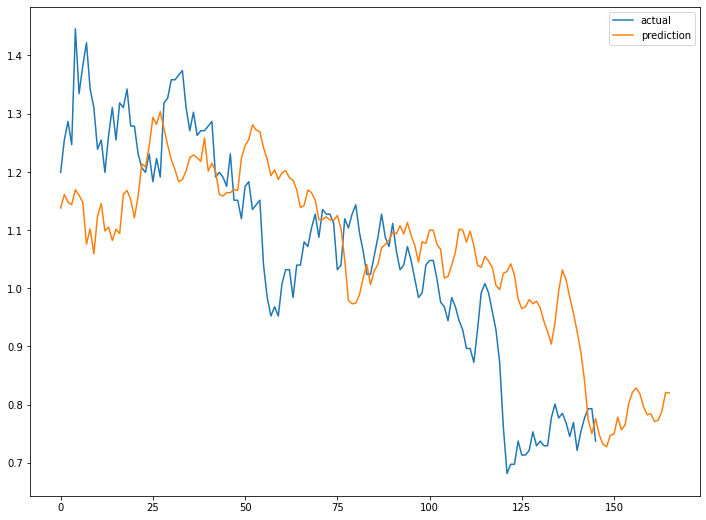

In [35]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [36]:
score = model.evaluate(X_test_t,y_test,batch_size=30)
print(score)

6/6 [==============================] - 0s 5ms/step - loss: 0.0018 - mse: 0.0036
[0.0018208699766546488, 0.0036417399533092976]


In [37]:
test_sc_df[('Close',)].describe()

count    178.000000
mean       1.078276
std        0.179670
min        0.681529
25%        0.984076
50%        1.103503
75%        1.199045
max        1.445860
Name: (Close,), dtype: float64

In [38]:
pd.DataFrame(pred).describe()

,0
count,166.000000
mean,1.062068
std,0.145033
min,0.727703
25%,0.985722
50%,1.093303
75%,1.167129
max,1.303633


Text(0.5, 1.0, 'Prices vs Predicted price Index: $Y_i$ vs $\\hat{Y}_i$')

findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


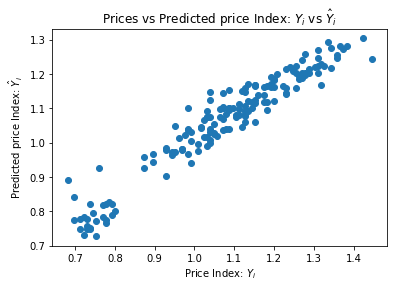

In [39]:
# 직선에 가까울 수록 정확도가 높다
y_pred = model.predict(X_test_t, batch_size=32)
plt.scatter(y_test, y_pred)
plt.xlabel("Price Index: $Y_i$")
plt.ylabel("Predicted price Index: $\hat{Y}_i$")
plt.title("Prices vs Predicted price Index: $Y_i$ vs $\hat{Y}_i$")